In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_shfqc_hdawg_pqsc import (
    descriptor_shfsg_shfqa_shfqc_hdawg_pqsc,
)

from laboneq.contrib.example_helpers.randomized_benchmarking_helper import (
    make_pauli_gate_map,
    clifford_parametrized,
    generate_play_rb_pulses,
)

from laboneq.contrib.example_helpers.feedback_helper import (
    state_emulation_pulse,
    create_calibration_experiment,
    create_discrimination_experiment,
)

from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

from zhinst.utils.shfqa.multistate import QuditSettings
from laboneq.analysis import calculate_integration_kernels
# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

In [2]:
descriptor = """\
instruments:
  SHFQC:
  - address: DEV12158
    uid: device_shfqc

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q0/drive_line_ef
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q1/drive_line_ef
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q2/drive_line_ef
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q3/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q3/drive_line_ef
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q4/drive_line
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q4/drive_line_ef
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q5/drive_line
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q5/drive_line_ef
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q2/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q3/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q3/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q4/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q4/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q5/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q5/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor, #descriptor_shfsg_shfqa_shfqc_hdawg_pqsc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

def lsg(qubit_str, line_str):
    return device_setup.logical_signal_groups[qubit_str].logical_signals[line_str]

lsg_keys = device_setup.logical_signal_groups.keys()

# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.04.17 15:50:03.062] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\Users\Kunky\Documents\SiQubit\laboneq_output\log
[2024.04.17 15:50:03.071] INFO    VERSION: laboneq 2.25.0
[2024.04.17 15:50:03.076] INFO    Connecting to data server at localhost:8004
[2024.04.17 15:50:03.196] INFO    Connected to Zurich Instruments LabOne Data Server version 24.01 at localhost:8004
[2024.04.17 15:50:03.216] WARNING SHFQC/QA:dev12158: Include the device options 'SHFQC/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.04.17 15:50:04.277] INFO    Configuring the device setup
[2024.04.17 15:50:04.386] INFO    The device setup is configured


In [3]:

num_qudits = len(lsg_keys)

ro_pulse_duration = 1e-6

qudits_params = {
"qudits":lsg_keys,
"ro_num_states": num_qudits * [2],
"ro_cent_f": 0,
"ro_df":     num_qudits * [10e6],
"ro_pin_range":   0,
"ro_pout_range":  0,
"ro_pulse_data": {},
"ro_pulse_delay": 0,
"ro_int_t": ro_pulse_duration,
"ro_int_delay": 0e-9,

"ro_int_weights": {},
"thresholds":{},
"ro_snr": num_qudits * [0],
"ro_fidelity": num_qudits * [0],
"ro_fidelity_ef": num_qudits * [0],
"ro_x_talk_matrix": {},
"wait_after_int": 5e-6,

"dr_cent_f": num_qudits * [7e9], # <= 3 different LO f, because ch1 and ch2 share the same LO, and same for ch3 and ch4, ch5 and ch6
"dr_df": num_qudits * [10e6],
"dr_df_ef": num_qudits * [10e6],
"dr_p_range":   num_qudits * [0],
"dr_pulse_data": num_qudits * [0.5],
"dr_pulse_data_ef": num_qudits * [0.5],
"dr_pi_pulse": {},
"dr_pi_pulse_ef": {},
"dr_pi/2_pulse": {},
"dr_pi/2_pulse_ef": {},
"T1": num_qudits * [0],
"T2": num_qudits * [0],
"T2_echo": num_qudits * [0],
"T2_Ramsey": num_qudits * [0],
"T2_CPMG": num_qudits * [0],
"T1_ef": num_qudits * [0],
"T2_echo_ef": num_qudits * [0],
"T2_Ramsey_ef": num_qudits * [0],
"T2_CPMG_ef": num_qudits * [0],
"1q_gate_fidelity": num_qudits * [0],
"2q_gate_fidelity": num_qudits * [0],
"dr_x_talk_matrix": {},
}

states_str = ["g", "e", "f", "h"]

In [4]:
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy as scy
from scipy.signal import gaussian
from scipy.optimize import leastsq
from scipy.stats import norm
from pylab import rcParams
import textwrap
import itertools
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid=exp_settings["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            # relax time after readout - for qubit relaxation to groundstate and signal processing
            with exp_spec.section(uid="relax", length=1e-6):
                exp_spec.reserve(signal="measure")

    return exp_spec

def exp_signal(exp_params, num_states=2):
    threshold = 0
    if "ef" in exp_params["exp_name"] or num_states >2:
        signals = [signal for signal_list in [
            [ExperimentSignal(("drive_" + qubit),   map_to=lsg(qubit, "drive_line")),
             ExperimentSignal(("drive_ef_" + qubit),map_to=lsg(qubit, "drive_line_ef")),
             ExperimentSignal(("measure_" + qubit), map_to=lsg(qubit, "measure_line")),
             ExperimentSignal(("acquire_" + qubit), map_to=lsg(qubit, "acquire_line")),  
            ] for qubit in exp_params["qubits"]
            ] for signal in signal_list
        ]
    else:
        signals = [signal for signal_list in [
                [   ExperimentSignal(("drive_" + qubit),   map_to=lsg(qubit, "drive_line")),                    
                    ExperimentSignal(("measure_" + qubit), map_to=lsg(qubit, "measure_line")),
                    ExperimentSignal(("acquire_" + qubit), map_to=lsg(qubit, "acquire_line")),  
                ] for qubit in exp_params["qubits"]
            ] for signal in signal_list
        ]  
    
    exp_signal = Experiment(uid=exp_params["exp_name"], signals= signals)
    return exp_signal

def compile_run(session, exp_params, exp):
    compiler_settings = None
    if "rb" in exp_params["exp_name"]:
        compiler_settings = {"SHFSG_MIN_PLAYWAVE_HINT": 256}

    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/{exp_params["exp_name"]}''', compiled_exp, interactive=exp_params["interactive"])
    if exp_params["plot_simulation"] == 1:
        plot_simulation(compiled_exp, start_time=exp_params["plt_start_time"], length=exp_params["plt_length"])
    return results

# def define_calibration(qudits_params):
#     # the calibration object will later be applied to the device setup
#     calibration = Calibration()

#     for qn in qudits_params["qudits"]:
#         calibration[lsg(qn, "acquire_line")] = SignalCalibration(
#             local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
#             oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
#                                     modulation_type = ModulationType.SOFTWARE),
#             # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
#             port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
#             range = qudits_params["ro_pin_range"],
#         )
#         # measure line
#         calibration[lsg(qn, "measure_line")] = SignalCalibration(
#             local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
#             oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
#                                 modulation_type = ModulationType.SOFTWARE),
#             port_delay = qudits_params["ro_pulse_delay"] ,
#             range = qudits_params["ro_pout_range"],
#         )
#         calibration[lsg(qn, "drive_line")] = SignalCalibration(
#             # verify which qubits share the same LOs!
#             local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
#             # each logical signal can have an oscillator associated with it
#             oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
#                                 modulation_type = ModulationType.HARDWARE),
#             range = qudits_params["dr_p_range"][int(qn[1])],
#         )
#         calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
#         # verify which qubits share the same LOs!
#         local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
#         # each logical signal can have an oscillator associated with it
#         oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
#                             modulation_type = ModulationType.HARDWARE),
#         range = qudits_params["dr_p_range"][int(qn[1])],
#         )
#     return calibration

# def res_spectroscopy(session, exp_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid=exp_params["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )
    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    amplitude_sweep = exp_params["ro_osc_gain"]
    if "amp_sweep" in exp_params.keys():
        amplitude_sweep = exp_params["amp_sweep"]

    exec_str = """
with exp.acquire_loop_rt(
    uid=exp_params["exp_name"] + "_shots",
    count=2**exp_params["num_averages"],
    acquisition_type=AcquisitionType.SPECTROSCOPY,
    averaging_mode= exp_params["average_mode"],
):
    with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
        # readout pulse and data acquisition
        with exp.section(uid="spectroscopy"):
            # resonator signal readout
            if "pulse" in exp_params["exp_name"]: 
                exp.play(signal="measure", pulse=exp_params['readout_pulse'])
            exp.acquire(
                signal="acquire",
                handle=exp_params["exp_name"],
                length=exp_params["integration_time"],
            )
        # relax time after readout - for qubit relaxation to groundstate and signal processing
        with exp.section(uid="relax", length=exp_params["wait_after_int"]):
            exp.reserve(signal="measure")
            exp.reserve(signal="acquire")
        """
    if "2D" in exp_params["exp_name"]:
        with exp.sweep(uid="res_amp", parameter=exp_params["amp_sweep"]):
            exec(exec_str)    
    else:
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"] + "_shots",
            count=2**exp_params["num_averages"],
            acquisition_type=AcquisitionType.SPECTROSCOPY,
            averaging_mode= exp_params["average_mode"],
        ):
            with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
                # readout pulse and data acquisition
                with exp.section(uid="spectroscopy"):
                    # resonator signal readout
                    if "pulse" in exp_params["exp_name"]: 
                        exp.play(signal="measure", pulse=exp_params['readout_pulse'])
                    exp.acquire(
                        signal="acquire",
                        handle=exp_params["exp_name"],
                        length=exp_params["integration_time"],
                    )
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                    exp.reserve(signal="measure")
                    exp.reserve(signal="acquire")
        # exec(exec_str) 

    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_cent_f"]),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        amplitude=amplitude_sweep,
        range = exp_params["ro_pout_range"]
    )
    cal["acquire"] = SignalCalibration(
        local_oscillator = Oscillator("ro_cent_f_acquire", frequency = exp_params["ro_cent_f"]),
        range = exp_params["ro_pin_range"]
    )
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)

    return results


def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode = ro_port_mode,
        )
        # measure line
        calibration[lsg(qn, "measure_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                modulation_type = ModulationType.SOFTWARE),
            port_delay = qudits_params["ro_pulse_delay"] ,
            range = qudits_params["ro_pout_range"],
            port_mode = ro_port_mode
        )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = qudits_params["dr_p_range"][int(qn[1])],
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

def res_spectroscopy(session, exp_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid=exp_params["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )
    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    amplitude_sweep = exp_params["ro_osc_gain"]
    if "amp_sweep" in exp_params.keys():
        amplitude_sweep = exp_params["amp_sweep"]

    exec_str = """
with exp.acquire_loop_rt(
    uid=exp_params["exp_name"] + "_shots",
    count=2**exp_params["num_averages"],
    acquisition_type=AcquisitionType.SPECTROSCOPY,
    averaging_mode= exp_params["average_mode"],
):
    with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
        # readout pulse and data acquisition
        with exp.section(uid="spectroscopy"):
            # resonator signal readout
            if "pulse" in exp_params["exp_name"]: 
                exp.play(signal="measure", pulse=exp_params['readout_pulse'])
            exp.acquire(
                signal="acquire",
                handle=exp_params["exp_name"],
                length=exp_params["integration_time"],
            )
        # relax time after readout - for qubit relaxation to groundstate and signal processing
        with exp.section(uid="relax", length=exp_params["wait_after_int"]):
            exp.reserve(signal="measure")
            exp.reserve(signal="acquire")
        """
    if "2D" in exp_params["exp_name"]:
        with exp.sweep(uid="res_amp", parameter=exp_params["amp_sweep"]):
            exec(exec_str)    
    else:
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"] + "_shots",
            count=2**exp_params["num_averages"],
            acquisition_type=AcquisitionType.SPECTROSCOPY,
            averaging_mode= exp_params["average_mode"],
        ):
            with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
                # readout pulse and data acquisition
                with exp.section(uid="spectroscopy"):
                    # resonator signal readout
                    if "pulse" in exp_params["exp_name"]: 
                        exp.play(signal="measure", pulse=exp_params['readout_pulse'])
                    exp.acquire(
                        signal="acquire",
                        handle=exp_params["exp_name"],
                        length=exp_params["integration_time"],
                    )
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                    exp.reserve(signal="measure")
                    exp.reserve(signal="acquire")
        # exec(exec_str) 

    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_cent_f"]),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        amplitude=amplitude_sweep,
        range = exp_params["ro_pout_range"]
    )
    cal["acquire"] = SignalCalibration(
        local_oscillator = Oscillator("ro_cent_f_acquire", frequency = exp_params["ro_cent_f"]),
        range = exp_params["ro_pin_range"]
    )
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)

    return results

def propagation_delay(session, exp_params, qudits_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid=exp_params["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency
    with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["delay_sweep"]):
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"] + "_shots",
            count=2**exp_params["delay_num_averages"],
            acquisition_type=AcquisitionType.INTEGRATION,
        ):
            # readout pulse and data acquisition
            with exp.section(uid="readout"):
                # play resonator excitation pulse
                exp.play(signal="measure", pulse=qudits_params["ro_pulse_data"]["q0"])
                # resonator signal readout
                exp.acquire(
                    signal="acquire", handle=exp_params["exp_name"], kernel= qudits_params["ro_pulse_data"]["q0"]
                )
            with exp.section(uid="relax"):
                exp.delay(signal="measure", time=qudits_params["wait_after_int"])
                
    cal = Calibration()
    cal["acquire"] = SignalCalibration(port_delay=exp_params["delay_sweep"])
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

def qubit_spec(session, exp_params, qudits_params):
    exp = exp_signal(exp_params)
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_freq_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"]
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                ge_pulse = qudits_params["dr_pi_pulse"] if "ef" in exp_params["exp_name"] else exp_params["dr_pulse_data"]                   

                with exp.section(uid="qubit_excitation_" + qubit):
                     exp.play(signal="drive_" + qubit, pulse = ge_pulse[qubit])
                
                if "ef" in exp_params["exp_name"]:
                    ef_str = "ef_"
                    with exp.section(
                        uid="qubit_excitation_ef_" + qubit,
                        play_after="qubit_excitation_" + qubit,
                        on_system_grid=True,
                        alignment=SectionAlignment.RIGHT,
                    ):
                        exp.play(signal="drive_ef_" + qubit, pulse=exp_params["dr_ef_pulse"][qubit])  

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                      )

    cal = Calibration()
    for qubit in exp_params["qubits"]:
        if "ef" in exp_params["exp_name"]:
            cal["drive_ef_"+ qubit] = SignalCalibration(
                oscillator=Oscillator(frequency=exp_params["freq_sweep"][int(qubit[1])],modulation_type=ModulationType.HARDWARE),     
            )  
        else:          
            cal["drive_"+ qubit] = SignalCalibration(
                local_oscillator=Oscillator(frequency=exp_params["dr_cent_f"][int(qubit[1])]),
                oscillator=Oscillator(frequency=exp_params["freq_sweep"][int(qubit[1])],modulation_type=ModulationType.HARDWARE),
                range=exp_params["dr_p_range"][int(qubit[1])],        
            )
    exp.set_calibration(cal)
    results = compile_run(session, exp_params, exp)
    return results

def rabi(session, exp_params,qudits_params):
    exp = exp_signal(exp_params)
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_rabi_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"]
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["amp_sweep"]):
            for qubit in exp_params["qubits"]:
                ef_str = ""
                amplitude = 1 if "ef" in exp_params["exp_name"] else exp_params["amp_sweep"][int(qubit[1])]
                ge_pulse = qudits_params["dr_pi_pulse"] if "ef" in exp_params["exp_name"] else exp_params["dr_pulse_data"] 

                with exp.section(uid="qubit_excitation_" + qubit):
                    exp.play(signal="drive_" + qubit, pulse = ge_pulse[qubit], amplitude = amplitude)
                if "ef" in exp_params["exp_name"]:
                    ef_str = "ef_"
                    with exp.section(
                        uid="qubit_excitation_ef_" + qubit,
                        play_after="qubit_excitation_" + qubit,
                        on_system_grid=True,
                        alignment=SectionAlignment.RIGHT,
                    ):
                        exp.play(signal="drive_ef_" + qubit, pulse=exp_params["dr_ef_pulse"][qubit], amplitude = exp_params["amp_sweep"][int(qubit[1])])
                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                      )

    cal = Calibration()
    for qubit in exp_params["qubits"]:
        dr_p_range = qudits_params["dr_p_range"][int(qubit[1])] if "ef" in exp_params["exp_name"] else exp_params["dr_p_range"][int(qubit[1])]
        cal["drive_"+ef_str + qubit] = SignalCalibration(range=dr_p_range)
    exp.set_calibration(cal)
    results = compile_run(session, exp_params, exp)
    return results

def t1(session, exp_params,qudits_params):
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shot",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                    exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    print("ef meas") if 'ef' in exp_params["exp_name"] else exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])]) 
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(
                        uid="qubit_excitation_ef_" + qubit,
                        play_after="qubit_excitation_" + qubit,
                        on_system_grid=True,
                        alignment=SectionAlignment.RIGHT,
                    ):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])

                    
                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                      )
    results = compile_run(session, exp_params, exp)
    return results

def ramsey(session, exp_params,qudits_params):
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shot",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
            # qubit drive
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    with exp.section(uid="qubit_excitation_ef_" + qubit, play_after="qubit_excitation_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi/2_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi/2_pulse_ef"][qubit])
                else: 
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
                        exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])]) 
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
     

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"],
                                      )
    results = compile_run(session, exp_params, exp)
    return results

def hahn_echo(session, exp_params,qudits_params):
    exp_name = exp_params["exp_name"] 
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=f"{exp_name}_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_name, parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    with exp.section(uid="qubit_excitation_ef_" + qubit, play_after="qubit_excitation_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi/2_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi/2_pulse_ef"][qubit])
                   
                else:
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
                        exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                        exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])                    
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str+ qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_name + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                )
    results = compile_run(session, exp_params, exp)
    return results

def cpmg(session, exp_params,qudits_params):
    exp_name = exp_params["exp_name"] 
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=f"{exp_name}_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_name, parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    with exp.section(uid="qubit_excitation_ef_" + qubit, play_after="qubit_excitation_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi/2_pulse_ef"][qubit]) 
                        for i in range(exp_params["num_cpmg"]):
                            exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                            exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                            exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi/2_pulse_ef"][qubit])
                else:
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
                        for i in range(exp_params["num_cpmg"]):
                            exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                            exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                            exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])                    
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_name + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                )
    results = compile_run(session, exp_params, exp)
                    
    return results

def rb_1q(session, exp_params, qudits_params):
    exp = exp_signal(exp_params)
    # outer loop - real-time, cyclic averaging in standard integration mode
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shots",
        count=2**exp_params["num_averages"],
        averaging_mode=exp_params["average_mode"],
        acquisition_type=AcquisitionType.DISCRIMINATION,
        # repetition_mode=RepetitionMode.AUTO,
    ):
        for qubit in exp_params["qubits"]:
            # inner loop - sweep over sequence lengths
            for seq_length in exp_params["seq_lengths"]:
                # innermost loop - different random sequences for each length
                for _ in range(exp_params["n_seq_per_length"]):
                    with exp.section(
                        length=exp_params["max_seq_duration"], alignment=SectionAlignment.RIGHT
                    ):
                        generate_play_rb_pulses(
                            exp, "drive_" + qubit, seq_length, clifford_parametrized, exp_params["gate_map"][qubit]
                        )
                    # readout and data acquisition
                    with exp.section():
                        exp.reserve("drive_" + qubit)
                        exp.play(signal="measure_" + qubit, pulse=qudits_params["ro_pulse_data"][qubit])
                        # trigger signal data acquisition
                        exp.acquire(
                            signal="acquire_" + qubit,
                            handle=f"acq_{seq_length}_"+qubit,  # use an individual handle for every sequence length
                            kernel=qudits_params["ro_int_weights"][qubit],
                        )
                    # relax time after readout - for qubit relaxation to groundstate and signal processing
                    with exp.section(length=exp_params["wait_after_int"]):
                        exp.reserve(signal="measure_"+qubit)

    results = compile_run(session, exp_params, exp)
    return results

def ro_f_1q(session, exp_params, qudits_params):
    qubit = exp_params["qubits"][0]
    num_states = exp_params["num_states"][0]
    exp = exp_signal(exp_params, num_states)
    
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shots",
        count=2**exp_params["num_averages"],
        averaging_mode=exp_params["average_mode"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        # repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
        # readout pulse and data acquisition         
            with exp.section(uid="readout_qubit_g_" + qubit):
                # play readout pulse on measure line
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=qudits_params["ro_pulse_data"][qubit],
                            handle=exp_params["exp_name"] + f"_{qubit}" +"_g", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_length=qudits_params["ro_int_t"],
                            reset_delay = exp_params["wait_after_int"]
                                    )
                
            with exp.section(uid = "qubit_excitation_e_" + qubit, play_after= "readout_qubit_g_" + qubit):
                exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            with exp.section(uid="readout_qubit_e_" + qubit, play_after="qubit_excitation_e_" + qubit):
                # play readout pulse on measure line
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=qudits_params["ro_pulse_data"][qubit],
                            handle=exp_params["exp_name"] + f"_{qubit}"+"_e", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_length=qudits_params["ro_int_t"],
                            reset_delay = exp_params["wait_after_int"],
                                    )
            if num_states > 2:
                with exp.section(uid = "qubit_excitation_e0_" + qubit, play_after= "readout_qubit_e_" + qubit):
                    exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                with exp.section(uid = "qubit_excitation_f0_" + qubit, play_after="qubit_excitation_e0_" + qubit):
                    exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                with exp.section(uid="readout_qubit_f_" + qubit, play_after="qubit_excitation_f0_" + qubit):
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}"+"_f", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_length=qudits_params["ro_int_t"],
                                reset_delay = exp_params["wait_after_int"]
                                        )
            # elif num_states > 3:
            #     with exp.section(uid = "qubit_excitation_e1_" + qubit, play_after= "readout_qubit_f_" + qubit):
            #         exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            #     with exp.section(uid = "qubit_excitation_f1_" + qubit, play_after="qubit_excitation_e0_" + qubit):
            #         exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
            #     with exp.section(uid = "qubit_excitation_h0_" + qubit, play_after="qubit_excitation_f0_" + qubit):
            #         exp.play(signal="drive_fh_"+ qubit, pulse = qudits_params["dr_pi_pulse_fh"][qubit])                                      
        
            #     with exp.section(uid="readout_qubit_h_" + qubit, play_after="qubit_excitation_h0_" + qubit):
            #         exp.measure(measure_signal="measure_"+qubit, 
            #                     measure_pulse=qudits_params["ro_pulse_data"][qubit],
            #                     handle=exp_params["exp_name"] + f"_{qubit}"+"_h", 
            #                     acquire_signal=f"acquire_{qubit}",
            #                     integration_length=qudits_params["ro_int_t"],
            #                     reset_delay = exp_params["wait_after_int"]
            #                             )
    
    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure_" + qubit] = SignalCalibration(
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE))
    exp.set_calibration(cal)
    
    results = compile_run(session, exp_params, exp)

    return results

def ro_trace_1q(session, exp_params, qudits_params):
    qubit = exp_params["qubits"][0]
    num_states = exp_params["num_states"][0]
    traces = []
    if exp_params["simulation"] == 1:
        ro_0 = exp_params["ro_pulse_g"]
        ro_1 = exp_params["ro_pulse_e"]
        ro_2 = exp_params["ro_pulse_f"]
    else:
        ro_0 = qudits_params["ro_pulse_data"][qubit]
        ro_1 = ro_0
        ro_2 = ro_1
    for state in range(num_states):
        exp = exp_signal(exp_params, num_states)
        
        exec_str = f''' 
with exp.section(uid=f"readout_{qubit}_{state}", play_after=play_after):
    exp.measure(measure_signal="measure_"+qubit, 
                measure_pulse=ro_{state},
                handle=exp_params["exp_name"] + f"_{qubit}" +f"_{state}", 
                acquire_signal=f"acquire_{qubit}",
                integration_kernel=qudits_params["ro_int_weights"][qubit],
                reset_delay = exp_params["wait_after_int"]
                        )
    '''
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"]+"_shots",
            count=2**exp_params["num_averages"],
            acquisition_type=AcquisitionType.RAW,
            # repetition_mode=RepetitionMode.AUTO,
        ):

            if state == 0:
                play_after = None
            else:
                with exp.section(uid = "qubit_excitation_g_" + qubit):
                    exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                if state == 1:
                    play_after = "qubit_excitation_g_" + qubit
                elif state == 2:
                    with exp.section(uid = "qubit_excitation_e_" + qubit, play_after="qubit_excitation_g_" + qubit):
                        exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                    play_after = "qubit_excitation_e_" + qubit
                    
            exec(exec_str)
        trace = compile_run(session, exp_params, exp)
        traces.append(trace.acquired_results[exp_params["exp_name"] + f"_{qubit}" +f"_{state}"].data)

    kernels = calculate_integration_kernels(traces)
    return kernels, traces

def ro_fidelity_1q(exp_params, qudits_params):
    qubit = exp_params["qubits"][0]
    if exp_params["simulation"] == 1:
        ro_0 = exp_params["ro_pulse_g"]
        ro_1 = exp_params["ro_pulse_e"]
        ro_2 = exp_params["ro_pulse_f"]
        print(f"simulation is true")
    else:
        ro_0 = qudits_params["ro_pulse_data"][qubit]
        ro_1 = ro_0
        ro_2 = ro_1
    qubit = exp_params["qubits"][0]
    print(qubit)
    num_states = exp_params["num_states"][0]
    exp = exp_signal(exp_params, num_states)
    if "thresholds" in exp_params["exp_name"]:
        acq_type = AcquisitionType.INTEGRATION
    elif "assignment" in exp_params["exp_name"]:
        acq_type = AcquisitionType.DISCRIMINATION

    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shots",
        count=1,
        acquisition_type=acq_type,
        # repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid= "repeat the measurement", parameter=LinearSweepParameter(uid = "dummy sweep", start = 1, stop=exp_params["num_points"], count=exp_params["num_points"])):
          
            with exp.section(uid="readout_qubit_g_" + qubit):
                # play readout pulse on measure line
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=ro_0,
                            handle=exp_params["exp_name"] + f"_{qubit}" +"_g", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_kernel=qudits_params["ro_int_weights"][qubit],
                            reset_delay = exp_params["wait_after_int"]
                                    )       
            with exp.section(uid = "qubit_excitation_e_" + qubit, play_after="readout_qubit_g_" + qubit):
                exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            with exp.section(uid="readout_qubit_e_" + qubit, play_after="qubit_excitation_e_" + qubit):
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=ro_1,
                            handle=exp_params["exp_name"] + f"_{qubit}"+"_e", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_kernel=qudits_params["ro_int_weights"][qubit],
                            reset_delay = exp_params["wait_after_int"]
                                        )
            if num_states == 3 or "ef" in exp_params["exp_name"]:
                with exp.section(uid = "qubit_excitation_e1_" + qubit, play_after="readout_qubit_e_" + qubit):
                    exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                with exp.section(uid = "qubit_excitation_f1_" + qubit, play_after="qubit_excitation_e1_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                    exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                with exp.section(uid="readout_qubit_f_" + qubit, play_after="qubit_excitation_f1_" + qubit):
                    exp.measure(measure_signal="measure_" + qubit, 
                                measure_pulse=ro_2,
                                handle=exp_params["exp_name"] + f"_{qubit}"+"_f", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"])
            # if num_states == 4 or "fh" in exp_params["exp_name"]:
            #     with exp.section(uid = "qubit_excitation_g2_" + qubit, play_after="readout_qubit_f_" + qubit):
            #         exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            #     with exp.section(uid = "qubit_excitation_ef_" + qubit, play_after="qubit_excitation_g2_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
            #         exp.play(signal="drive_ef_"+qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
            #     with exp.section(uid = "qubit_excitation_fh_" + qubit, play_after="qubit_excitation_ef" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
            #         exp.play(signal="drive_fh_"+qubit, pulse = qudits_params["dr_pi_pulse_fh"][qubit])
            #     with exp.section(uid="readout_qubit_h_" + qubit, play_after="qubit_excitation_fh_" + qubit):
            #         # play readout pulse on measure line
            #         exp.measure(measure_signal="measure_"+qubit, 
            #                     measure_pulse=qudits_params["ro_pulse_data"][qubit],
            #                     handle=exp_params["exp_name"] + f"_{qubit}"+"_h", 
            #                     acquire_signal=f"acquire_{qubit}",
            #                     integration_kernel=qudits_params["ro_int_weights"][qubit],
            #                     reset_delay = exp_params["wait_after_int"])

    if "assignment" in exp_params["exp_name"]:
        cal = Calibration()
        print(f'enter {exp_params["thresholds"]} for {qubit}' )
        cal["acquire_" + qubit] = SignalCalibration(threshold=exp_params["thresholds"])#qudits_params["thresholds"][qubit])
        exp.set_calibration(cal)
    # print(exp.get_calibration())
    results_raw = compile_run(session, exp_params, exp)
    results = {}
    state_str = ["g","e", "f"]
    for i in range(num_states):
       results[i] = results_raw.get_data(exp_params["exp_name"] + f"_{qubit}" +f"_{state_str[i]}")
    return results, results_raw

def fb_1q(session, exp_params,qudits_params):
    exp = exp_signal(exp_params, num_states = 2)
    with exp.acquire_loop_rt(
        count=exp_params["num_points"],
        acquisition_type=AcquisitionType.DISCRIMINATION,
        averaging_mode=AveragingMode.SINGLE_SHOT, 
        uid="shots",
    ):
            # iterate over the letters of the given pattern
        qubit = exp_params["qubits"][0]
        last = None
        
        with exp.section(uid=f"dr_{qubit}"):
            exp.play(signal=f"drive_{qubit}", pulse= qudits_params["dr_pi_pulse"][qubit])
        with exp.section(uid=f"readout_{qubit}", play_after=f"dr_{qubit}"):
            # play resonator excitation pulse
            exp.play(signal=f"measure_{qubit}", pulse=qudits_params["ro_pulse_data"][qubit])
            # resonator signal readout
            exp.acquire(
                signal=f"acquire_{qubit}", handle=exp_params["exp_name"], kernel= qudits_params["ro_int_weights"][qubit]
            )

        # real-time feedback, fetching the measurement data identified by handle from the QA unit specified in the descriptor
        # determines automatically if local (SHFQC only) or global (through PQSC) feedback path is to be used
        with exp.match(uid=f"feedback_{qubit}", handle=exp_params["exp_name"], play_after=f"readout_{qubit}"):
            with exp.case(state=0):
                exp.play(signal=f"drive_{qubit}", pulse=exp_params["x180"])
            with exp.case(state=1):
                exp.play(signal=f"drive_{qubit}", pulse=exp_params["x0"])
            if exp_params["num_states"][0] > 2:
                with exp.case(state=2):
                    exp.play(signal=f"drive_{qubit}", pulse=exp_params["x90"])
            
        # introduce a delay between repetitions of the pattern, for visual distinction
        with exp.section(uid=f"wait_after_int_{qubit}", play_after=f"readout_{qubit}", length=exp_params["wait_after_int"]):
            exp.reserve(signal=f"acquire_{qubit}")

    cal = Calibration()
    cal[f"acquire_{qubit}"] = SignalCalibration(threshold=qudits_params["thresholds"][qubit])
    exp.set_calibration(cal)    
    results = compile_run(session, exp_params, exp)
    # print(exp)
    return results

def cr_gate(session, exp_params,qudits_params):
        # set up sweep parameter - drive pulse length

    exp = Experiment(
        uid="cr Tuneup",
        signals=[
            ExperimentSignal(("drive_0"), map_to=lsg("q0", "drive_line")),
            ExperimentSignal(("drive_1"), map_to=lsg("q1", "drive_line")),
            ExperimentSignal(("drive_cr"), map_to=lsg("q0", "drive_line")),
            ExperimentSignal(("measure_0"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire_0"), map_to=lsg("q0", "acquire_line")),
            ExperimentSignal(("measure_1"), map_to=lsg("q1", "measure_line")),
            ExperimentSignal(("acquire_1"), map_to=lsg("q0", "acquire_line")),
        ],
    )
    ## experimental pulse sequence
    # outer loop - real-time, cyclic averaging in standard integration mode
    with exp.acquire_loop_rt(
        uid="shots",
        count=pow(2, exp_params["num_averages"]),
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real-time sweep of qubit drive pulse amplitude
        with exp.sweep(uid="sweep", parameter=exp_params["length_sweep"]):
            with exp.section(
                uid="drive", alignment=SectionAlignment.RIGHT, length=exp_params["length_sweep"].stop + 2 * exp_params["x90"].length
            ):
                # qubit excitation - assume something is done to both qubits
                with exp.section(
                    uid="qubit_excitation",
                    on_system_grid=True,
                    alignment=SectionAlignment.RIGHT,
                ):
                    exp.play(signal="drive_0", pulse=exp_params["x90"])
                    exp.play(signal="drive_1", pulse=exp_params["x90"], amplitude=0.4)
                # play CR pulse and sweep its length
                with exp.section(
                    uid="cr_gate",
                    play_after="qubit_excitation",
                    on_system_grid=True,
                    alignment=SectionAlignment.LEFT,
                ):
                    exp.play(signal="drive_cr", pulse=exp_params["cr_pulse"], length=exp_params["length_sweep"])
            # qubit readout pulses and data acquisition
            with exp.section(uid="qubit_readout", play_after="drive"):
                # play readout pulse
                exp.play(signal="measure_0", pulse=qudits_params["ro_pulse_data"]["q0"])
                exp.play(signal="measure_1", pulse=qudits_params["ro_pulse_data"]["q1"])
                # signal data acquisition
                exp.acquire(
                    signal="acquire_0",
                    handle="ac_0",
                    kernel=qudits_params["ro_int_weights"]["q0"],
                )
                # signal data acquisition
                exp.acquire(
                    signal="acquire_1",
                    handle="ac_1",
                    kernel=qudits_params["ro_int_weights"]["q1"],
                )
            # relax time after readout - for signal processing and qubit relaxation to ground state
            with exp.section(uid="relax", length=10e-9):
                exp.reserve(signal="measure_0")

    results = compile_run(session, exp_params, exp)
    return results

# plot parameters
pi=np.pi
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
rcParams['figure.figsize'] = 8, 4
plt.rc('font', size=SMALL_SIZE, style='normal', weight = 'normal')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = ['#1f77b4', # 1
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf', # 10
          ]

def plot_sweeper(f, result, unwrap = True, deg = True):
    """Plot results from Sweeper"""
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Power (dBm)')
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Frequency (GHz)')
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    plt.show()

def plot_n(x, y, z, do_plot = 1):
    """Plot multiple results"""
    if do_plot == 1: 
        power = 10*np.log10(np.abs(z)**2/50*1000)
        phase = np.angle(z, deg = True)

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        for i in range(len(power)):
            ax0.plot(x/1e9, power[i], '.-', color = colors[i], label = f'gain = {y[i]}')
            ax1.plot(x/1e9, phase[i], '.-', color = colors[i], label = f'gain = {y[i]}')
        ax0.set_ylabel('Power (dBm)')
        ax1.set_ylabel('Phase (deg)')
        ax1.set_xlabel('Frequency (GHz)')
        ax0.legend(loc='upper left')
        ax1.legend(loc='upper left')
        ax0.grid()
        ax1.grid()
        fig.tight_layout()
        fig.align_ylabels([ax0, ax1])

def plot_2d(x, y, z, do_plot = 1):
    """2D plot"""
    if do_plot == 1:   
        x = x/1e9
        x0 = np.zeros(len(x)+1)    
        x0[:-1] = x - (x[1]-x[0])/2
        x0[-1]= x[-1] + (x[1]-x[0])/2    
        y0 = np.zeros(len(y)+1)
        y0[:-1] = y - (y[1]-y[0])/2
        y0[-1]= y[-1] + (y[1]-y[0])/2

        z_abs = 10*np.log10(np.abs(z)**2/50*1000)
        z_angle = np.angle(z, deg = True)
        X, Y = np.meshgrid(x0 ,y0)

        fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
        c0 = ax0.pcolormesh(X, Y,z_abs)
        ax0.set_yticks(y)
        ax0.set_ylabel('Gain')
        ax0.set_title('Power (dBm)')
        fig.colorbar(c0, ax=ax0)

        c1 = ax1.pcolormesh(X, Y, z_angle)
        ax1.set_yticks(y)
        ax1.set_xlabel('Offset frequency (GHz)')
        ax1.set_ylabel('Gain')
        ax1.set_title('Phase (degree)')
        fig.colorbar(c1, ax=ax1)

        fig.tight_layout()
        plt.show() 

def plot_readout_IQ(integration_length, data, do_plot=1):
    """Plot results in I-Q plane"""
    data = data/integration_length
    if do_plot == 1:
        fig, ax = plt.subplots()
        if len(data.shape) == 1:        
            ax.scatter(data.real, data.imag, label = f'data 0') 
        else:
            for i in range(len(data)):
                ax.scatter(data[i].real, data[i].imag, label = f'data {i}')
        ax.plot(0,0, 'o', color = 'black', label = 'Point 0')
        ax.set_xlabel('Real (Vrms)')
        ax.set_ylabel('Imag (Vrms)')
        ax.grid()
        ax.legend()
        ax.axis('equal')
        plt.tight_layout()
        plt.show()

def plot_qubit_readout_amp_phase(integration_length, x, ys, unwrap = False, deg = True, do_plot = True, xlabel = None, title= None):
    """Plot results in amplitude vs x and phase vs x"""
    if do_plot == 1:
        amp = np.abs(ys)/integration_length
        phase = np.unwrap(np.angle(ys/integration_length, deg = deg)) if unwrap is True else np.angle(ys, deg = deg)
        phase_unit = 'deg' if deg is True else 'rad'   
        
        fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
        ax0.plot(x, amp, '.-', color = 'steelblue', label = f'Amplitude')
        # ax0.set_title(f'Measure propagation delay')
        ax0.legend(loc='upper left')
        ax0.set_ylabel('Amplitude (Vrms)')
        ax1.plot(x, phase, '.-', color = 'orange', label = f'phase')
        ax1.legend(loc='upper left')
        ax1.set_xlabel('x')
        if xlabel != None:
            ax1.set_xlabel(xlabel)
        ax1.set_ylabel(f'Phase ({phase_unit})')
        fig.align_ylabels([ax0, ax1])
        ax0.grid()
        ax1.grid()
        ax0.set_title(title)
        plt.tight_layout()
        plt.show()

In [18]:
# parameters for all resonator spectroscopy experiment (cw, pulse and 2d)
start_freq = 350.0e6
stop_freq = 450.0e6
num_points = 201
num_averages = 10
average_mode = AveragingMode.CYCLIC # AveragingMode.SEQUENTIAL #

ro_cent_f = 1e9
ro_pin_range = -5
ro_pout_range = -30


integration_time = 2e-6
wait_after_int = integration_time + 5e-6
freq_sweep = LinearSweepParameter(uid = f"res_freq_q0", start = start_freq, stop = stop_freq, count = num_points, axis_name="Frequency [Hz]")

# define the experiment with the frequency sweep relevant for qubit 0
exp_params_res = {
    "ro_cent_f": ro_cent_f,
    "ro_pout_range": ro_pout_range,
    "ro_pin_range": ro_pin_range,
    "freq_sweep": freq_sweep,
    "num_averages": num_averages,
    "integration_time": integration_time,
    "wait_after_int": wait_after_int,
    "average_mode": average_mode,
    "plot_simulation": 1,
    "plt_start_time": 0,
    "plt_length":10e-6,
    "interactive": False,
    }

# parameters if output waveforms is pulse
envelop_duration = 2e-6
envelop_amplitude = 1
envelop_width = envelop_duration
envelop_waveform  = pulse_library.gaussian_square(uid = "readout_envelop_q0", length = envelop_duration, amplitude = envelop_amplitude, width = envelop_width, sigma = 0.2)



[2024.04.17 15:52:50.858] INFO    Starting LabOne Q Compiler run...
[2024.04.17 15:52:50.893] INFO    Schedule completed
[2024.04.17 15:52:50.953] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:52:50.955] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.17 15:52:50.956] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:52:50.957] INFO      device_shfqc     0         21            0           0         0  
[2024.04.17 15:52:50.960] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:52:50.961] INFO      TOTAL                      21            0                     0  
[2024.04.17 15:52:50.963] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:52:50.967] INFO    Finished LabOne Q Compiler run.
[2024.04.17 15:52:50.971] INFO    Configuring the device setup
[2024.04.17 15:52:51.086] INF

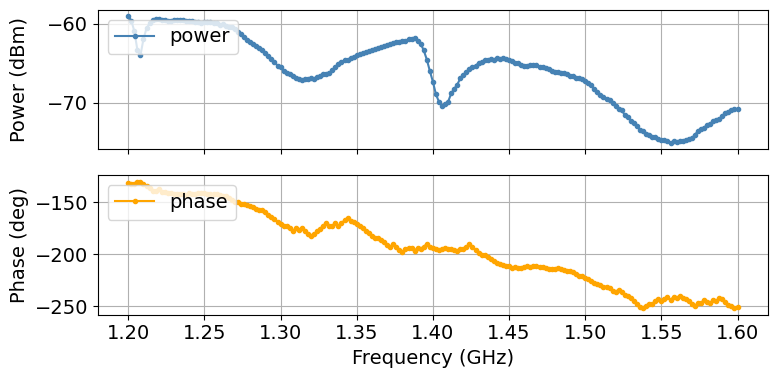

In [17]:
exp_params_cw_res_spec = exp_params_res
exp_params_cw_res_spec.update({
    "exp_name": "cw",
    "wait_after_int": wait_after_int,
    "ro_osc_gain": 0.5,
    "plot_simulation": 0,
})

results_cw_res = res_spectroscopy(session, exp_params_cw_res_spec)

f = np.transpose(np.array(results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].axis))
data  = results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].data
plot_sweeper(f + exp_params_cw_res_spec["ro_cent_f"], data)

[2024.04.17 15:53:38.285] INFO    Starting LabOne Q Compiler run...
[2024.04.17 15:53:38.321] INFO    Schedule completed
[2024.04.17 15:53:38.418] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:53:38.420] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.17 15:53:38.421] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:53:38.422] INFO      device_shfqc     0         21            0           0         0  
[2024.04.17 15:53:38.424] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:53:38.425] INFO      TOTAL                      21            0                     0  
[2024.04.17 15:53:38.426] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 15:53:38.433] INFO    Finished LabOne Q Compiler run.
[2024.04.17 15:53:38.441] INFO    Configuring the device setup
[2024.04.17 15:53:38.552] INF

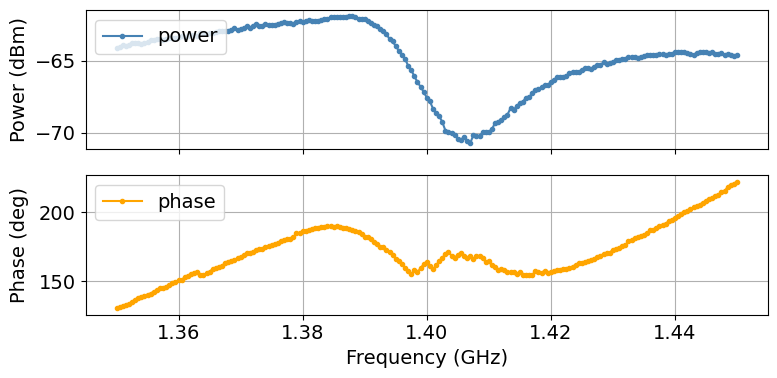

In [19]:
exp_params_cw_res_spec = exp_params_res
exp_params_cw_res_spec.update({
    "exp_name": "cw",
    "wait_after_int": wait_after_int,
    "ro_osc_gain": 0.5,
    "plot_simulation": 0,
})

results_cw_res = res_spectroscopy(session, exp_params_cw_res_spec)

f = np.transpose(np.array(results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].axis))
data  = results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].data
plot_sweeper(f + exp_params_cw_res_spec["ro_cent_f"], data)

In [28]:
num_qudits = len(lsg_keys)

ro_pulse_duration = 1e-6

qudits_params = {
"qudits":lsg_keys,
"ro_num_states": num_qudits * [2],
"ro_cent_f": 0,
"ro_df":     num_qudits * [395.0e6],
"ro_pin_range":   0,
"ro_pout_range":  0,
"ro_pulse_data": {},
"ro_pulse_delay": 0,
"ro_int_t": ro_pulse_duration,
"ro_int_delay": 0e-9,

"ro_int_weights": {},
"thresholds":{},
"ro_snr": num_qudits * [0],
"ro_fidelity": num_qudits * [0],
"ro_fidelity_ef": num_qudits * [0],
"ro_x_talk_matrix": {},
"wait_after_int": 5e-6,

"dr_cent_f": num_qudits * [7e9], # <= 3 different LO f, because ch1 and ch2 share the same LO, and same for ch3 and ch4, ch5 and ch6
"dr_df": num_qudits * [10e6],
"dr_df_ef": num_qudits * [10e6],
"dr_p_range":   num_qudits * [0],
"dr_pulse_data": num_qudits * [0.5],
"dr_pulse_data_ef": num_qudits * [0.5],
"dr_pi_pulse": {},
"dr_pi_pulse_ef": {},
"dr_pi/2_pulse": {},
"dr_pi/2_pulse_ef": {},
"T1": num_qudits * [0],
"T2": num_qudits * [0],
"T2_echo": num_qudits * [0],
"T2_Ramsey": num_qudits * [0],
"T2_CPMG": num_qudits * [0],
"T1_ef": num_qudits * [0],
"T2_echo_ef": num_qudits * [0],
"T2_Ramsey_ef": num_qudits * [0],
"T2_CPMG_ef": num_qudits * [0],
"1q_gate_fidelity": num_qudits * [0],
"2q_gate_fidelity": num_qudits * [0],
"dr_x_talk_matrix": {},
}

states_str = ["g", "e", "f", "h"]

In [29]:
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy as scy
from scipy.signal import gaussian
from scipy.optimize import leastsq
from scipy.stats import norm
from pylab import rcParams
import textwrap
import itertools
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter


ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
print(ro_port_mode)
def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode=ro_port_mode,

        )
        # measure line
        calibration[lsg(qn, "measure_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                modulation_type = ModulationType.SOFTWARE),
            port_delay = qudits_params["ro_pulse_delay"] ,
            range = qudits_params["ro_pout_range"],
            port_mode=ro_port_mode,
        )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = 5,
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

calibration = define_calibration(qudits_params)
device_setup.set_calibration(calibration)
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)

amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-1.0, stop = 1.0, count=301)

def charge_stability_diagram():
    exp = Experiment(uid="exp", 
        signals = [
                ExperimentSignal(("drive_g1"),   map_to=lsg("q0", "drive_line")), 
#                 ExperimentSignal(("drive_g2"),   map_to=lsg("q1", "drive_line")),                   
                ExperimentSignal(("measure_g"), map_to=lsg("q0", "measure_line")),
                ExperimentSignal(("acquire_g"), map_to=lsg("q0", "acquire_line")),  
        ]  
    )
    with exp.acquire_loop_rt(
        uid="exp",
        count=2**0,
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.CYCLIC,
    ):
        with exp.sweep(uid='sweep amp g1', parameter=amp_sweep_g1):
            with exp.section(uid="g1_sweep"):
                with exp.section(uid = "g1_1"):
                    exp.play(signal = "drive_g1", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180) # note that the phase does not affect the output amplitude 

#                 for i in range(int(g1_len/g2_len)):
#                     if i == 0:
#                         str_g2 = None
#                     else:
#                         str_g2 = f"g2_sweep_{i-1}"

#                     with exp.section(uid= f"g2_sweep_{i}", alignment=SectionAlignment.RIGHT, play_after = str_g2):
#                         exp.play(signal = "drive_g2", pulse=g2_pulse, amplitude = 0.1+0.1*i, phase=180)
                with exp.section(uid=f"readout"):
                    exp.acquire(
                        signal="acquire_g",
                        handle="results",
                        length=100e-6,
                    )
                with exp.section(uid=f"relax", length=2e-6, play_after= f"readout"):
                    # exp.reserve(signal="measure")
                    exp.reserve(signal="acquire_g")
# 
    cal = Calibration()
  
    cal["drive_g1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=5)
#     cal["drive_g2"] = SignalCalibration(
#         local_oscillator=Oscillator(frequency=0),
#         port_mode=PortMode.LF,
#         oscillator=Oscillator(frequency=0),
#         range=0)
    cal["acquire_g"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=405.0e6),
        range=0)
    exp.set_calibration(cal)

               
    compiler_settings = None
    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 

    return results

results = charge_stability_diagram()

data = results.acquired_results["results"].data

PortMode.LF
[2024.04.17 16:00:16.203] INFO    Resolved modulation type of oscillator 'osc_223' on signal 'acquire_g' to HARDWARE
[2024.04.17 16:00:16.204] INFO    Resolved modulation type of oscillator 'osc_221' on signal 'drive_g1' to HARDWARE
[2024.04.17 16:00:16.207] INFO    Starting LabOne Q Compiler run...
[2024.04.17 16:00:16.288] INFO    Schedule completed
[2024.04.17 16:00:25.739] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.04.17 16:00:25.740] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.17 16:00:25.741] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.04.17 16:00:25.743] INFO      device_shfqc        0          9            0           0         0  
[2024.04.17 16:00:25.745] INFO      device_shfqc_sg     0       1216          301           3       192  
[2024.04.17 16:00:25.747] INFO     ─────────────────────────────────────────────────────────────────────

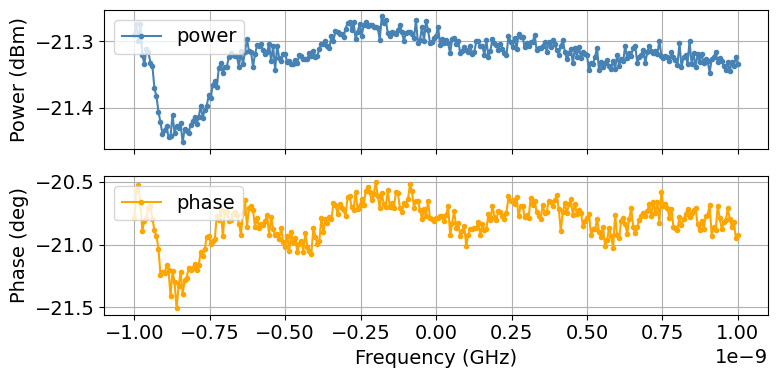

In [30]:
plot_sweeper(amp_sweep_g1, data)

In [41]:
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy as scy
from scipy.signal import gaussian
from scipy.optimize import leastsq
from scipy.stats import norm
from pylab import rcParams
import textwrap
import itertools
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter


ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
print(ro_port_mode)
def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode=ro_port_mode,

        )
        # measure line
#         calibration[lsg(qn, "measure_line")] = SignalCalibration(
#             local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
#             oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
#                                 modulation_type = ModulationType.SOFTWARE),
#             port_delay = qudits_params["ro_pulse_delay"] ,
#             range = qudits_params["ro_pout_range"],
#             port_mode=ro_port_mode,
#         )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = qudits_params["dr_p_range"][int(qn[1])],
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

calibration = define_calibration(qudits_params)
device_setup.set_calibration(calibration)
g1_len = 100e-6
g2_len = 2e-6

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.1, length = g1_len, can_compress=True)

amp_sweep_g1 = LinearSweepParameter("amp_g1", start=0.0, stop = 0.8, count=101)

def charge_stability_diagram():
    exp = Experiment(uid="exp", 
        signals = [
                ExperimentSignal(("drive_g1"),   map_to=lsg("q0", "drive_line")), 
                ExperimentSignal(("measure_g"), map_to=lsg("q0", "measure_line")),
                ExperimentSignal(("acquire_g"), map_to=lsg("q0", "acquire_line")),  
        ]  
    )
    with exp.acquire_loop_rt(
        uid="exp",
        count=2**0,
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.CYCLIC,
    ):
        with exp.sweep(uid='sweep amp g1', parameter=amp_sweep_g1):
            with exp.section(uid="g1_sweep"):
#                 with exp.section(uid = "g1_1"):
                exp.play(signal = "drive_g1", pulse=g1_pulse, amplitude = amp_sweep_g1)
                exp.acquire(
                        signal="acquire_g",
                        handle="results",
                        length=100e-6,
                    )
            with exp.section(uid="relax", length=0.1e-6):
                    exp.reserve(signal="acquire_g")

    cal = Calibration()
  
    cal["drive_g1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=0)
    cal["acquire_g"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=421.5e6),
        range=0)
    exp.set_calibration(cal)

               
    compiler_settings = None
    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 

    return results

results = charge_stability_diagram()

data = results.acquired_results["results"].data

PortMode.LF
[2024.02.27 16:37:54.974] INFO    Resolved modulation type of oscillator 'osc_533' on signal 'acquire_g' to HARDWARE
[2024.02.27 16:37:54.977] INFO    Resolved modulation type of oscillator 'osc_531' on signal 'drive_g1' to HARDWARE
[2024.02.27 16:37:54.979] INFO    Starting LabOne Q Compiler run...
[2024.02.27 16:37:55.018] INFO    Schedule completed
[2024.02.27 16:37:57.424] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.02.27 16:37:57.426] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.02.27 16:37:57.428] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.02.27 16:37:57.429] INFO      device_shfqc        0          9            0           0         0  
[2024.02.27 16:37:57.430] INFO      device_shfqc_sg     0        413          101           2       128  
[2024.02.27 16:37:57.433] INFO     ─────────────────────────────────────────────────────────────────────

[2024.02.27 16:37:59.066] ERROR   SHFQC/QA:dev12158:ch0:spectroscopy: The number of measurements acquired (15) does not match the number of measurements defined (101). Possibly the time between measurements within a loop is too short, or the measurement was not started.


[2024.02.27 16:37:59.176] INFO    Finished near-time execution.
[2024.02.27 16:37:59.307] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.02.27 16:37:59.317] INFO    Resolved modulation type of oscillator 'osc_533' on signal 'acquire_g' to HARDWARE
[2024.02.27 16:37:59.319] INFO    Resolved modulation type of oscillator 'osc_531' on signal 'drive_g1' to HARDWARE
[2024.02.27 16:37:59.320] INFO    Starting LabOne Q Compiler run...
[2024.02.27 16:37:59.354] INFO    Schedule completed
[2024.02.27 16:38:01.893] INFO    Finished LabOne Q Compiler run.
[2024.02.27 16:38:01.921] INFO    Writing html file to C:\Users\Kunky\Documents\SiQubit\Pulse_Sheets\csd_2024-02-27-16-37-59.html


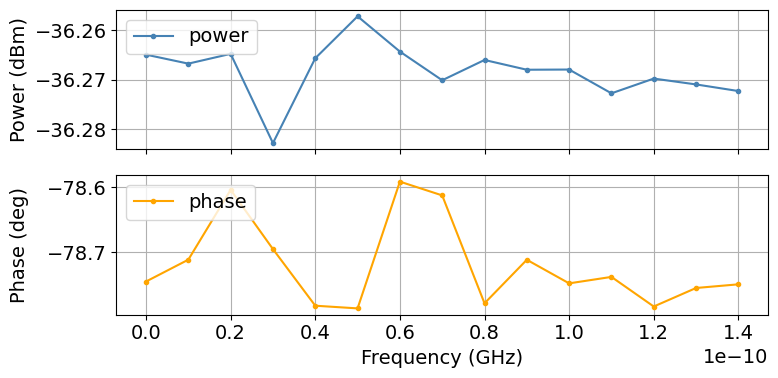

In [40]:
plot_sweeper(amp_sweep_g1, data)

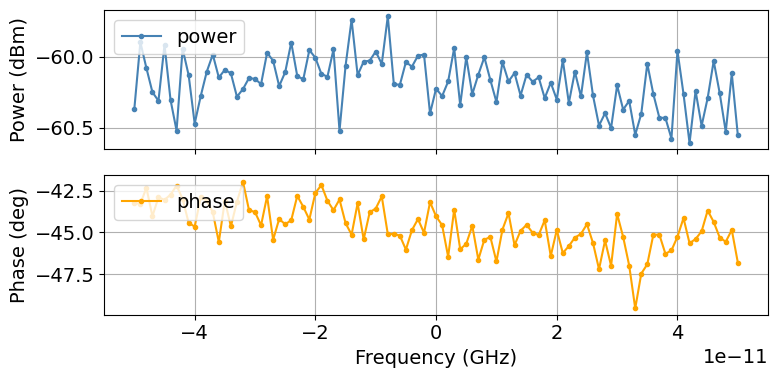

In [88]:
plot_sweeper(amp_sweep_g1, data)

In [35]:
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy as scy
from scipy.signal import gaussian
from scipy.optimize import leastsq
from scipy.stats import norm
from pylab import rcParams
import textwrap
import itertools
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter


ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
print(ro_port_mode)
def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode=ro_port_mode,

        )
        # measure line
        calibration[lsg(qn, "measure_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                modulation_type = ModulationType.SOFTWARE),
            port_delay = qudits_params["ro_pulse_delay"] ,
            range = qudits_params["ro_pout_range"],
            port_mode=ro_port_mode,
        )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = qudits_params["dr_p_range"][int(qn[1])],
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

calibration = define_calibration(qudits_params)
device_setup.set_calibration(calibration)
g1_len = 10e-6
g2_len = 2e-6

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)

amp_sweep_g1 = LinearSweepParameter("amp_g1", start=0.0, stop = 0.05, count=101)

def charge_stability_diagram():
    exp = Experiment(uid="exp", 
        signals = [
                ExperimentSignal(("drive_g1"),   map_to=lsg("q0", "drive_line")), 
                ExperimentSignal(("drive_g2"),   map_to=lsg("q1", "drive_line")),                   
                ExperimentSignal(("measure_g"), map_to=lsg("q0", "measure_line")),
                ExperimentSignal(("acquire_g"), map_to=lsg("q0", "acquire_line")),  
        ]  
    )
    with exp.acquire_loop_rt(
        uid="exp",
        count=2**5,
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.CYCLIC,
    ):
        with exp.sweep(uid='sweep amp g1', parameter=amp_sweep_g1):
            with exp.section(uid="g1_sweep"):
                with exp.section(uid = "g1_1"):
                    exp.play(signal = "drive_g1", pulse=g1_pulse, amplitude = amp_sweep_g1)

                for i in range(int(g1_len/g2_len)):
                    with exp.section(uid= f"g2_sweep_{i}", alignment=SectionAlignment.RIGHT):
                        exp.play(signal = "drive_g2", pulse=g2_pulse, amplitude = 0*0.1+0*0.1*i)
                        exp.acquire(
                            signal="acquire_g",
                            handle="results",
                            length=100e-6,
                        )
                    with exp.section(uid="relax", length=1e-6):
                        exp.reserve(signal="acquire_g")

    cal = Calibration()
  
    cal["drive_g1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=5e9),
        range=0)
    cal["drive_g2"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=5e9),
        range=0)
    exp.set_calibration(cal)

               
    compiler_settings = None
    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 

    return results

results = charge_stability_diagram()

data = results.acquired_results["results"].data

PortMode.LF
[2024.02.27 15:04:16.699] INFO    Starting LabOne Q Compiler run...
[2024.02.27 15:04:16.956] INFO    Schedule completed
[2024.02.27 15:04:21.176] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.02.27 15:04:21.178] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.02.27 15:04:21.181] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.02.27 15:04:21.183] INFO      device_shfqc        0         13            0           0         0  
[2024.02.27 15:04:21.185] INFO      device_shfqc_sg     0        617          101           2       128  
[2024.02.27 15:04:21.186] INFO      device_shfqc_sg     1         21            1           1        64  
[2024.02.27 15:04:21.187] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.02.27 15:04:21.188] INFO      TOTAL                        651          102                   192  
[2024.02.27 15:04:2

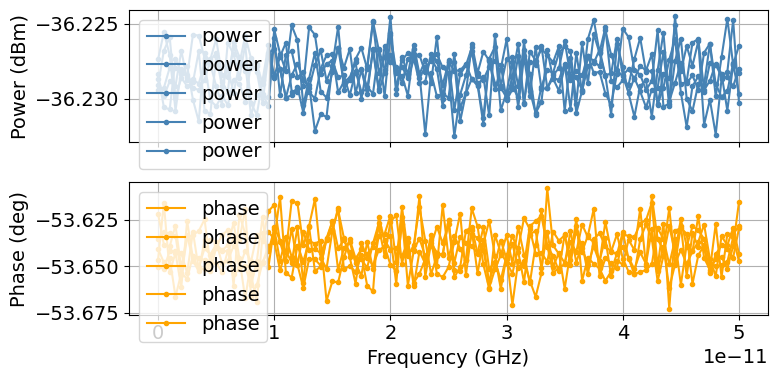

In [34]:
plot_sweeper(amp_sweep_g1, data)

In [91]:
def plot_sweeper(f, result, unwrap = True, deg = True):
    """Plot results from Sweeper"""
#     f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Power (dBm)')
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Voltage')
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    plt.show()

In [100]:
import zhinst.ziPython as zi
import zhinst.utils as utils
import zhinst.deviceutils.shfqa as shfqa_utils
import zhinst.deviceutils.shfsg as shfsg_utils

from zhinst.utils.shf_sweeper import (
    ShfSweeper,
    AvgConfig,
    RfConfig,
    SweepConfig,
    TriggerConfig,
    EnvelopeConfig
)
from zhinst.deviceutils import shfqa as shfqc_utils
# from helper import * 

C:\Users\Kunky\AppData\Local\Temp\ipykernel_16540\2264475283.py:3: DeprecationWarning: zhinst-deviceutils is deprecated. Please use zhinst-utils instead.
  import zhinst.deviceutils.shfqa as shfqa_utils
C:\Users\Kunky\AppData\Local\Temp\ipykernel_16540\2264475283.py:4: DeprecationWarning: zhinst-deviceutils is deprecated. Please use zhinst-utils instead.
  import zhinst.deviceutils.shfsg as shfsg_utils
